- label 1 : 불만족
- label 0: 만족

- [Kaggle data set url](https://www.kaggle.com/competitions/santander-customer-satisfaction/data)

- XGBoost : n_estimators 값에 따라 n개의 결정 트리를 만든다.
- 이전 트리의 오차에 가중치를 두어 다음 트리를 만든다.
- 그렇게 만들어진 트리들의 예측을 합하여 최종 예측을 만든다.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/santander_customer_satisfaction/train_santander.csv', encoding = 'latin-1')
print('dataset shape : ', cust_df.shape)
cust_df.head(3)

dataset shape :  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


### Data Preprocessing

In [10]:
cust_df.info()
# Null 값은 없다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [11]:
# 전체 data에서 만족과 불만족의 비율
print(cust_df['TARGET'].value_counts())

0    73012
1     3008
Name: TARGET, dtype: int64


In [12]:
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
# total_cnt_of_1 = (cust_df['TARGET'] == 1).sum() 이렇게 써도 괜찮지만, 위의 코드가 더 일반적이다
# True는 1로, False는 0으로 취급
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

unsatisfied 비율은 0.04


In [13]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [14]:
# 어? var3는 최소값이 -999999다.
# 116개나 있는 것 보면 NaN 값 또는 특정 예외 값을 해당 값으로 변환한 것 같다.
print(cust_df.var3.value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


> **이상치가 있는 column이 더 존재하는 지 알고 싶다면 어떻게 하지?**

In [15]:
import pandas as pd

# 값에 -999999가 포함된 열 추출
columns_with_minus999999 = cust_df.columns[cust_df.isin([-999999]).any()]
# df와 동일한 모양의 불리언 DataFrame을 생성합니다.
# 각 요소는 해당하는 df의 요소가 -999999와 동일하면 True이고, 그렇지 않으면 False입니다.

# 메서드는 불리언 DataFrame에 적용되며 주어진 축을 따라
# 어느 하나라도 True인 요소가 있는지를 나타내는 Series를 반환합니다.
print(columns_with_minus999999)

# isin 메서드를 사용하여 불리언 마스크를 만들고 any 메서드를 사용하여 각 열에 최소한 하나의 True 값이 있는지 확인합니다.

Index(['var3'], dtype='object')


In [16]:
# Outlier를 가장 많은 값인 2로 변환
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

# feature set과 label set 분리
X_features = cust_df.iloc[: , : -1]
y_labels = cust_df.iloc[: , -1]
print('feature data shape : {0}'.format(X_features.shape))

feature data shape : (76020, 369)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)


In [18]:
# data 가 불균형한 분포를 이루고 있기
# target값 분포도가 학습 data와 test data set에 모두 비슷하게 추출되었는 지 확인
print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [19]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state= 0)

#### **XGBoost 모델 학습 & hyper parmeter 튜닝**


- Hyperopt를 사용할 때 fmin() 함수 호출 전에 모델을 fit 시키는 것은 선택 사항이지만, 초기에 몇 번의 훈련을 통해 모델을 미리 초기화하고 몇 가지 하이퍼 파라미터를 테스트하는 것이 초기에 어떤 하이퍼 파라미터가 좋은지 더 잘 결정할 수 있도록 도움이 될 수 있다.

In [4]:
# hyper parameter 튜닝 전 기본 xgboost 모델의 값
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [20]:
xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = 0.05, random_state = 156, tree_method = "gpu_hist")

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 100, eval_metric = "auc", eval_set = [(X_tr, y_tr),(X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83583	validation_1-auc:0.81078
[1]	validation_0-auc:0.83768	validation_1-auc:0.81229
[2]	validation_0-auc:0.83877	validation_1-auc:0.81298
[3]	validation_0-auc:0.84098	validation_1-auc:0.81437
[4]	validation_0-auc:0.84160	validation_1-auc:0.81489
[5]	validation_0-auc:0.84334	validation_1-auc:0.81542
[6]	validation_0-auc:0.84514	validation_1-auc:0.81567
[7]	validation_0-auc:0.84660	validation_1-auc:0.81682
[8]	validation_0-auc:0.84744	validation_1-auc:0.81713
[9]	validation_0-auc:0.84929	validation_1-auc:0.81891
[10]	validation_0-auc:0.84987	validation_1-auc:0.81853
[11]	validation_0-auc:0.85099	validation_1-auc:0.82043
[12]	validation_0-auc:0.85221	validation_1-auc:0.82064
[13]	validation_0-auc:0.85322	validation_1-auc:0.82138
[14]	validation_0-auc:0.85570	validation_1-auc:0.82252
[15]	validation_0-auc:0.85664	validation_1-auc:0.82300
[16]	validation_0-auc:0.85823	validation_1-auc:0.82380
[17]	validation_0-auc:0.85884	validation_1-auc:0.82401
[18]	validation_0-au

> **KFOLD 함수**

```python
from sklearn.model_selection import KFold

# n_splits는 폴드의 개수, shuffle은 데이터를 섞을지 여부 등을 설정합니다.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# kf.split(X)를 호출하면 각 폴드의 인덱스를 반환합니다.
for train_index, test_index in kf.split(data):
  print(train_index, test_index)
    # train_index: 훈련 세트의 인덱스, test_index: 검증 세트의 인덱스
    # 여기에서는 이 인덱스를 사용하여 데이터를 나누거나 모델을 훈련시키는 등의 작업을 수행합니다.

```
> test_index [20272 20273 20274 ... 60813 60814 60815]

> train_index [0     1     2 ... 20269 20270 20271]

In [21]:
# HyperOpt를 이용한 베이지안 최적화 기반 XGBoost의 하이퍼 파라미터 튜닝 수행
from hyperopt import hp
# 하이퍼파라미터 탐색 공간 정의
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [7]:
# # 최적화할 목적 함수 정의
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 이전에 만들어준 탐색공간을 parameter로 가지는 모델을 만들고 평가한 후 평가 지표를 반환
# params는 하이퍼파라미터 조합을 나타냄

def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators = 100,
                          max_depth = int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          colsample_bytree = search_space['colsample_bytree'],
                          learning_rate = search_space['learning_rate'],
                          tree_method = "gpu_hist")

  # 3개의 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list = [ ]

  # 3-fold 방식 적용
  #  KFold 함수는 각 폴드를 훈련(train) 및 검증(validation) 세트로 나누는 데 사용
  kf = KFold(n_splits = 3)
  for tr_index, val_index in kf.split(X_train):
    print(tr_index, val_index) # 실험 후 삭제 예정
    #kf.split(X_train)으로 추출된 학습, 검증 index값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
    # early_sopping : 30회로 설정, 추출된 학습과 검증 data로 sgbclassifier 학습 수행
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = "auc", eval_set = [(X_tr, y_tr), (X_val, y_val)])
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)

  return -1 * np.mean(roc_auc_list)

In [15]:
# 하이퍼파라미터 최적화 수행
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[94]	validation_0-auc:0.87223	validation_1-auc:0.83587
[95]	validation_0-auc:0.87254	validation_1-auc:0.83622
[96]	validation_0-auc:0.87263	validation_1-auc:0.83607
[97]	validation_0-auc:0.87270	validation_1-auc:0.83590
[98]	validation_0-auc:0.87289	validation_1-auc:0.83582
[99]	validation_0-auc:0.87314	validation_1-auc:0.83603
[20272 20273 20274 ... 60813 60814 60815]
[    0     1     2 ... 20269 20270 20271]
[0]	validation_0-auc:0.85752	validation_1-auc:0.80509
[1]	validation_0-auc:0.86790	validation_1-auc:0.81561
[2]	validation_0-auc:0.87297	validation_1-auc:0.81893
[3]	validation_0-auc:0.87737	validation_1-auc:0.81864
[4]	validation_0-auc:0.88214	validation_1-auc:0.82321
[5]	validation_0-auc:0.88443	validation_1-auc:0.82450
[6]	validation_0-auc:0.88579	validation_1-auc:0.82602
[7]	validation_0-auc:0.88802	validation_1-auc:0.82730
[8]	validation_0-auc:0.89092	validation_1-auc:0.82644
[9]	validation_0-auc:0.89275	validation_1-auc:0.82701
[10]	valid

In [22]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(0.05474899952019795, 5),
                        max_depth=int(6.0), min_child_weight=int(5.0),
                        colsample_bytree=round(0.7182634686833416, 5),
                        tree_method = "gpu_hist"
                       )

# evaluation metric 을 auc로, early stopping은 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 100, eval_metric = "auc", eval_set = [(X_tr, y_tr), (X_val, y_val)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[: ,1])
print('ROC AUC :{0:4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83418	validation_1-auc:0.81210
[1]	validation_0-auc:0.84129	validation_1-auc:0.81570
[2]	validation_0-auc:0.84361	validation_1-auc:0.81709
[3]	validation_0-auc:0.84394	validation_1-auc:0.81886
[4]	validation_0-auc:0.85009	validation_1-auc:0.82198
[5]	validation_0-auc:0.85206	validation_1-auc:0.82189
[6]	validation_0-auc:0.85175	validation_1-auc:0.82345
[7]	validation_0-auc:0.85205	validation_1-auc:0.82412
[8]	validation_0-auc:0.85186	validation_1-auc:0.82409
[9]	validation_0-auc:0.85302	validation_1-auc:0.82522
[10]	validation_0-auc:0.85443	validation_1-auc:0.82846
[11]	validation_0-auc:0.85608	validation_1-auc:0.82846
[12]	validation_0-auc:0.85712	validation_1-auc:0.82853
[13]	validation_0-auc:0.85821	validation_1-auc:0.82888
[14]	validation_0-auc:0.85876	validation_1-auc:0.82925
[15]	validation_0-auc:0.85918	validation_1-auc:0.82923
[16]	validation_0-auc:0.86000	validation_1-auc:0.82917
[17]	validation_0-auc:0.86062	validation_1-auc:0.82917
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

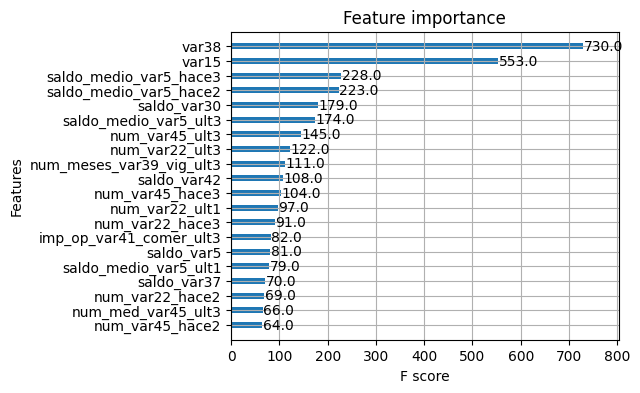

In [24]:
# xgboost의 plot_importances() 메서드 사용
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1, figsize = (5,4))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)
# height 매개변수는 중요도 플롯에서 막대의 높이를 제어
# 여러 서브플롯을 포함하는 큰 그림 내에서 플롯의 배치를 제어하려는 경우 유용
# ax 매개변수를 전달함으로써 plot_importance 함수에게 새로운 축을 생성하는 대신 지정된 축을 사용하게 함